In [1]:
#!/usr/bin/env python
# coding: utf-8
import sys
sys.path.append('..')
import umbrella_mesh
import elastic_rods
import linkage_vis
from umbrella_mesh import UmbrellaEnergyType
from bending_validation import suppress_stdout as so
from visualization_helper import *

import pipeline_helper, importlib, design_optimization_analysis
with so(): importlib.reload(pipeline_helper)
with so(): importlib.reload(design_optimization_analysis)

from pipeline_helper import UmbrellaOptimizationCallback, allEnergies, allGradientNorms, allDesignObjectives, allDesignGradientNorms, set_joint_vector_field, show_center_joint_normal, show_joint_normal

from design_optimization_analysis import DesignOptimizationAnalysis

import umbrella_optimization
import umbrella_optimization_finite_diff
from umbrella_optimization import OptEnergyType

import numpy as np
import numpy.linalg as la

import pickle, gzip

from configuration import *


import parallelism
parallelism.set_max_num_tbb_threads(24)
parallelism.set_hessian_assembly_num_threads(8)
parallelism.set_gradient_assembly_num_threads(8)

### Initialization

In [2]:
name = 'printing/hive'
input_path = '../../data/{}.json.gz'.format(name)

handleBoundary = False
io, input_data, target_mesh, curr_um, thickness, target_height_multiplier = parse_input(input_path, handleBoundary = handleBoundary, handlePivots = False)
# target_height_multiplier = 1
# curr_um = pickle.load(gzip.open('../../output/lilium_top_four_parameters_optimized_rest_state_equilibrium_2022_01_19_18_33_target_height_factor_5.0.pkl.gz', 'r'))

#### Pin Rigid Motion

In [3]:
use_pin = False

driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1
OPTS.beta = 1e-6
OPTS.niter = 300
OPTS.verboseNonPosDef = False

rod_colors = get_color_field(curr_um, input_data)

# lview = linkage_vis.LinkageViewer(curr_um, width=1024, height=600)
# lview.update(scalarField = rod_colors)
# lview.show()

import mesh
view = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh, width=1024, height=600)
set_surface_view_options(view, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
view.averagedMaterialFrames = True
view.showScalarField(rod_colors)
view.show()

Renderer(camera=PerspectiveCamera(aspect=1.7066666666666668, children=(PointLight(color='#999999', position=(0…

In [5]:
view.getCameraParams()

view.getSize()

(1024, 600)

In [6]:
from equilibrium_solve_analysis import EquilibriumSolveAnalysis
eqays = EquilibriumSolveAnalysis(curr_um)
def eqm_callback(prob, i):
    eqays.record(prob)
    if (i % 2 == 0):
        view.showScalarField(rod_colors)

configure_umbrella_pre_deployment(curr_um, thickness, target_height_multiplier)


allGradientNorms(curr_um)

{'Full': 0.0018277735925779975,
 'Elastic': 1.2330509036673048e-11,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0018274773438366502,
 'AngleBoundPenalty': 3.2906891242233856e-05}

In [ ]:
break_input_angle_symmetry(curr_um)

view.showScalarField(rod_colors)

results = staged_deployment(curr_um, np.logspace(-3, 0, 4), eqm_callback, OPTS, fixedVars)

results.success

In [ ]:
eqays.plot()

In [ ]:
# use_pin = True

# driver = curr_um.centralJoint()
# jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

# configure_umbrella_true_equlibrium(curr_um, thickness, target_height_multiplier)

# allEnergies(curr_um)

# OPTS.niter = 100

# results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

# results.success

In [ ]:
# import registration
# R, t = registration.register_points(curr_um.XJointPositions().reshape(-1,3), curr_um.XJointTgtPositions().reshape(-1,3))
# V = target_mesh.vertices()
# V_reg = R @ V.transpose() + np.repeat(t[:, np.newaxis],  len(V), axis = 1)
# target_mesh_reg = mesh.Mesh(V_reg.transpose(), target_mesh.elements())
# view2 = linkage_vis.LinkageViewerWithSurface(curr_um, target_mesh_reg, width=1024, height=600)
# set_surface_view_options(view2, color = 'green', surface_color = 'gray', umbrella_transparent = False, surface_transparent = True)
# view2.averagedMaterialFrames = True
# view2.showScalarField(rod_colors)
# view2.show()

In [ ]:
# use_pin = False

# driver = curr_um.centralJoint()
# jdo = curr_um.dofOffsetForJoint(driver)
# fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

### Initialize Design Optimization

In [ ]:
configure_umbrella_optimization(curr_um)
# curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

import py_newton_optimizer
opt_opts = py_newton_optimizer.NewtonOptimizerOptions()
opt_opts.gradTol = 1e-8
opt_opts.verbose = 10
opt_opts.beta = 1e-6
opt_opts.niter = 600
opt_opts.verboseNonPosDef = False

results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = opt_opts, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

opt_opts.niter = 50

results.success

# import force_analysis
# force_analysis.UmbrellaForceAnalysis(curr_um)
# v2 = force_analysis.UmbrellaForceFieldVisualization(curr_um)
# v2.show()

In [ ]:
optimizer = umbrella_optimization.UmbrellaOptimization(curr_um, opt_opts, 2.5, -1, False, fixedVars)

optimizer.beta = 1 * 1e6
optimizer.gamma = 1
optimizer.eta = 0
optimizer.zeta = 0# 1e1
optimizer.iota = 0
# arm_length_lower_bound = input_data["plate_edge_length"] / 30 * 32
arm_length_lower_bound = input_data["plate_edge_length"] / 19.918 * 15

rest_height_optimizer = umbrella_optimization.UmbrellaRestHeightsOptimization(optimizer)
single_rest_height_optimizer = umbrella_optimization.UmbrellaSingleRestHeightOptimization(rest_height_optimizer)

rest_height_optimizer.newPt(rest_height_optimizer.params())

original_design_parameters = rest_height_optimizer.params()

doptays = DesignOptimizationAnalysis(rest_height_optimizer)
def eqm_callback(prob, i):
    eqays.record(prob)
    if (i % 2 == 0):
        view.showScalarField(rod_colors)

import time
pipeline_helper.prev_time_stamp = time.time()

uo = rest_height_optimizer.get_parent_opt()

uo.equilibriumOptimizer.options.verbose = 1
#uo.equilibriumOptimizer.options.verboseWorkingSet = True
uo.equilibriumOptimizer.options.gradTol = 1e-10
# Hold the closest points fixed in the target-attraction term of the equilibrium solve:
# this seems to make the design optimization much more robust.
uo.setHoldClosestPointsFixed(True, False)

In [ ]:
tfview = pipeline_helper.TargetFittingVisualization(curr_um, uo.target_surface_fitter, view)
cb = pipeline_helper.UmbrellaOptimizationCallback(rest_height_optimizer, view, True, False, 1, rod_colors, doptays.record, tfview=tfview)

In [15]:
algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 200, 0.005, 1e-5, cb, arm_length_lower_bound)

In [16]:
rest_height_optimizer.reset_joint_target_with_closest_points()
# curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 1000, 0.005, 1e-5, cb, arm_length_lower_bound)

In [17]:
rest_height_optimizer.reset_joint_target_with_closest_points()
# curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
#algorithm = umbrella_optimization.OptAlgorithm.BFGS
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 1000, 0.005, 1e-5, cb, arm_length_lower_bound)

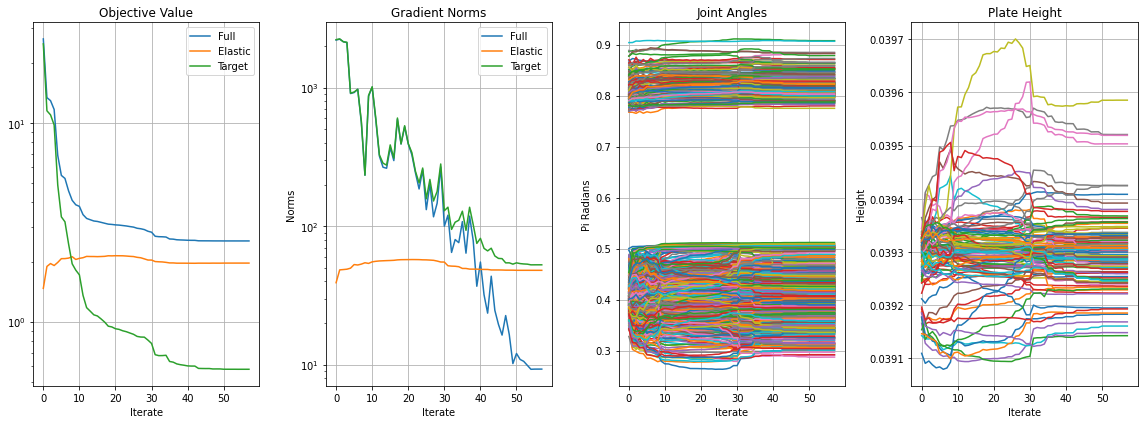

In [16]:
import time

from matplotlib import pyplot as plt
doptays.plot()

In [19]:
rest_height_optimizer.beta = 1 * 1e7
rest_height_optimizer.reset_joint_target_with_closest_points()
# curr_um.scaleInputPosWeights(0.1, bdryMultiplier = 1.0)

algorithm = umbrella_optimization.OptAlgorithm.NEWTON_CG
solverStatus = umbrella_optimization.optimize(rest_height_optimizer, algorithm, 10000, 0.005, 1e-5, cb, arm_length_lower_bound)

In [20]:
rest_height_optimizer.beta, rest_height_optimizer.gamma, rest_height_optimizer.eta

(10000000.0, 0.9999999999999999, 0.0)

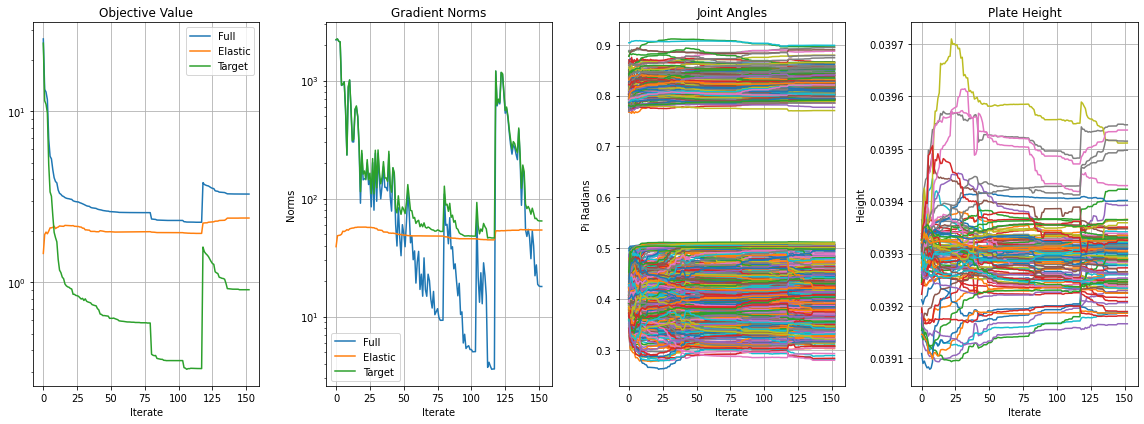

In [21]:
import time

from matplotlib import pyplot as plt
doptays.plot()

### Get true equilibrium state

In [22]:
use_pin = True

driver = curr_um.centralJoint()
jdo = curr_um.dofOffsetForJoint(driver)
fixedVars = (list(range(jdo, jdo + 6)) if use_pin else []) + curr_um.rigidJointAngleDoFIndices()

configure_umbrella_true_equlibrium(curr_um, thickness, target_height_multiplier)

allEnergies(curr_um)

OPTS.niter = 100

results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)

results.success

0	-114	5.59362e-08	5.59362e-08	1	0
1	-114	1.44284e-06	1.44284e-06	1	0
2	-114	2.52177e-11	2.52177e-11	1	0


True

In [25]:
# import force_analysis
# force_analysis.UmbrellaForceAnalysis(curr_um)
# v2 = force_analysis.UmbrellaForceFieldVisualization(curr_um)
# v2.show()

In [26]:
# assert 0
import pickle 
import gzip

pickle.dump(curr_um, gzip.open('../../data/optim/{}_optimized_equilibrium_{}_target_height_factor_{}.pkl.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"), target_height_multiplier), 'w'))
# load_um = pickle.load(gzip.open('test_pickle_um.pkl.gz', 'r'))
import importlib, load_jsondata
importlib.reload(load_jsondata)
load_jsondata.update_optimized_json(input_path, rest_height_optimizer.params(), output_json_path = '../../data/optim/{}_optimized_params_{}.json'.format(name, time.strftime("%Y_%m_%d_%H_%M")), optim_spacing_factor = target_height_multiplier, handleBoundary = handleBoundary, handlePivots = False)



In [27]:

from load_jsondata import write_deformed_config
output_path = '../../data/optim/{}_optimized_rendering_output_{}.json.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"))
write_deformed_config(curr_um, input_path, output_path, write_stress = False, is_rest_state = False, handleBoundary = handleBoundary)

### Undeployment

In [33]:
configure_umbrella_undeployment_step_one(curr_um, thickness, target_height_multiplier)

In [34]:
allEnergies(curr_um)

{'Full': -108.4997289260067,
 'Elastic': 0.15658282605047252,
 'Deployment': -108.65636203472168,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 5.028266451932367e-05}

In [35]:
OPTS.niter = 10

In [40]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
results.success

0	-111.144	0.746961	0.746961	1	1
1	-111.151	0.319767	0.319767	1	1
2	-111.155	0.11822	0.11822	1	1
3	-111.158	0.0995339	0.0995339	1	1
4	-111.162	0.100735	0.100735	1	1
5	-111.165	0.114697	0.114697	1	1
6	-111.171	0.154464	0.154464	1	1
7	-111.18	0.197804	0.197804	1	1
8	-111.185	0.0935059	0.0935059	1	1
9	-111.193	0.0883039	0.0883039	1	1
10	-111.209	0.0872517	0.0872517	1	1


False

In [41]:
configure_umbrella_undeployment_step_two(curr_um)

In [42]:
allEnergies(curr_um)

{'Full': 0.9451144547356013,
 'Elastic': 0.9437792238900328,
 'Deployment': 0.0,
 'Repulsion': 0.0,
 'Attraction': 0.0,
 'AngleBoundPenalty': 0.00133523084556835}

In [43]:
OPTS.niter = 500

In [ ]:
results = umbrella_mesh.compute_equilibrium(curr_um, callback = eqm_callback, options = OPTS, fixedVars = fixedVars, elasticEnergyIncreaseFactorLimit=2.5)
results.success

0	0.945114	2.72013	2.72013	1	1
1	0.501251	9.54644	9.54644	1	1
2	0.400437	2.27909	2.27909	1	1
3	0.377636	0.514114	0.514114	1	1
4	0.341995	0.465272	0.465272	1	1
5	0.288127	0.501122	0.501122	1	1
6	0.216741	0.49007	0.49007	1	1
7	0.140748	0.465472	0.465472	1	1
8	0.0810657	0.42745	0.42745	1	1
9	0.0470941	0.37241	0.37241	0.125	1
10	0.0455685	0.383755	0.383755	1	1
11	0.0432748	0.0709823	0.0709823	1	1
12	0.040713	0.0752255	0.0752255	1	1
13	0.0370807	0.0554091	0.0554091	1	1
14	0.0324975	0.0905157	0.0905157	1	1
15	0.0276299	0.180647	0.180647	1	1
16	0.0232226	0.273665	0.273665	1	1
17	0.01956	0.344827	0.344827	1	1
18	0.0165979	0.400462	0.400462	1	1
19	0.0159586	0.0490079	0.0490079	1	1
20	0.0155176	0.0632279	0.0632279	1	1
21	0.0148311	0.0762865	0.0762865	1	1
22	0.0138477	0.144864	0.144864	1	1
23	0.013309	0.0331676	0.0331676	1	1
24	0.012589	0.157552	0.157552	1	1
25	0.0124255	0.0115443	0.0115443	1	1
26	0.012367	0.00752409	0.00752409	1	1
27	0.012264	0.00775678	0.00775678	1	1
28	0.0120694	0.0133569	0.01

In [38]:
import pickle 
import gzip

pickle.dump(curr_um, gzip.open('../../data/optim/{}_optimized_rest_state_{}_target_height_factor_{}.pkl.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M"), target_height_multiplier), 'w'))
write_deformed_config(curr_um, output_path, output_path, write_stress = False, is_rest_state = True, handleBoundary = handleBoundary)

In [7]:
# import importlib, load_jsondata, time
# importlib.reload(load_jsondata)
# import json, gzip
# from load_jsondata import update_optimized_json
# input_data = json.load(gzip.open('../../data/optim/tigridia_optimized_params_2022_01_23_12_51.json'))
# handleBoundary = True
# name = 'tigridia'
# load_jsondata.update_optimized_json('../../data/optim/tigridia_optimized_params_2022_01_23_12_51.json', input_data['optim_heights'], output_json_path = '../../data/optim/{}_optimized_params_{}.json.gz'.format(name, time.strftime("%Y_%m_%d_%H_%M")), optim_spacing_factor = 1, handleBoundary = handleBoundary)
